# Shapley Values for interpretability
### Links!
- https://github.com/jwalluww/Machine-Learning-with-Python/blob/master/Bayesian%20Logistic%20Regression_bank%20marketing.ipynb
- https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
- https://blog.dominodatalab.com/shap-lime-python-libraries-part-1-great-explainers-pros-cons/

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Banking dataset from github <br>
- label: "y", whether they opened an account

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv',header=0)

In [3]:
df1=df

***
***
***
# LIME

This is an imbalance dataset...

In [4]:
df1.y.value_counts()

0    36548
1     4640
Name: y, dtype: int64

Separate out Y and x

In [5]:
y = df1["y"].map({0:0, 1:1}) # Mostly commonly used to map yes to 1 and no to 0

X = df1.drop("y", axis=1)

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

Target leakage...just take my word for it

In [7]:
X.drop("duration",inplace=True,axis=1)

In [8]:
X.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
dtype: object

### Create pipeline
#### Start with binarizing categorical variables and then run the model

Split features num from cat

In [9]:
from sklearn.compose import ColumnTransformer # deal with all variable types in one block
from sklearn.preprocessing import OneHotEncoder # Look at me, I'm a data scientist!
from sklearn.pipeline import Pipeline # Run the whole model process in one block
from sklearn.model_selection import train_test_split, GridSearchCV # splitting data and finding ideal hyperparameters
from sklearn.metrics import accuracy_score, classification_report

# Our algorithms, by from the easiest to the hardest to intepret.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

In [10]:
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6
3,39,services,married,high.school,no,no,no,cellular,apr,fri,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2


In [11]:
num_features = ["age", "campaign", "pdays", "previous", "emp_var_rate", 
                "cons_price_idx", "cons_conf_idx","euribor3m", "nr_employed"]

cat_features = ["job", "marital", "education","default", "housing", "loan",
                "contact", "month", "day_of_week", "poutcome"]

In [12]:
# Transform numerical features by just passing them through, then provide list
# Transform categorical features by one hot encoder, then provide list
preprocessor = ColumnTransformer([("numerical","passthrough",num_features),
                                  ("categorical",OneHotEncoder(sparse=False,handle_unknown="ignore"),cat_features)])

Above simply sets up the preprocessor, now set up the pipeline and models below

In [13]:
# Logistic Regression
lr_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42))])

# Decision Tree
dt_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", DecisionTreeClassifier(class_weight="balanced"))])

# Random Forest
rf_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", RandomForestClassifier(class_weight="balanced", n_estimators=100, n_jobs=-1))])

# XGBoost
xgb_model = Pipeline([("preprocessor", preprocessor), 
                      # Add a scale_pos_weight to make it balanced
                      ("model", XGBClassifier(scale_pos_weight=(1 - y.mean()), n_jobs=-1))])

Split data below!

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

#### Logistic Regression

Grid search hypterparameters

In [15]:
# lr_model - the model in question
# model__C - 
# n_jobs - "-1" runs your computations in parallel
# cv - cross validation, so we're doing 5-fold cross validation
# scoring - accuracy is chosen here (True Pos + True Neg / Total)
gs = GridSearchCV(lr_model, {"model__C": [1, 1.3, 1.5]}, n_jobs=-1, cv=5, scoring="accuracy")
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['age',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                          

View parameters and score

In [16]:
print(gs.best_params_)
print(gs.best_score_)

{'model__C': 1.5}
0.8294200662433966


In [17]:
lr_model.set_params(**gs.best_params_)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical', 'passthrough',
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp_var_rate',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed']),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dt...
              

Fit model on entire training set and calculate accuracy on test set

In [18]:
lr_model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical', 'passthrough',
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp_var_rate',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed']),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dt...
              

Generate predictions

In [19]:
y_pred=lr_model.predict(X_test)

In [20]:
accuracy_score(y_test,y_pred)

0.8277899166464352

In [21]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90     10965
           1       0.35      0.62      0.45      1392

    accuracy                           0.83     12357
   macro avg       0.65      0.74      0.67     12357
weighted avg       0.88      0.83      0.85     12357



Gymnastics to show feature names

In [24]:
preprocessor=lr_model.named_steps["preprocessor"]

In [25]:
ohe_categories=preprocessor.named_transformers_["categorical"].categories_

In [26]:
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_features, ohe_categories) for val in vals]

In [27]:
all_features = num_features + new_ohe_features

Quick peak at dataframe

In [28]:
pd.DataFrame(lr_model.named_steps["preprocessor"].transform(X_train), columns=all_features).head()

,age,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,job__admin.,...,month__oct,month__sep,day_of_week__fri,day_of_week__mon,day_of_week__thu,day_of_week__tue,day_of_week__wed,poutcome__failure,poutcome__nonexistent,poutcome__success
0,26.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.856,5191.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,59.0,1.0,999.0,0.0,-2.9,92.201,-31.4,0.884,5076.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,28.0,6.0,999.0,0.0,1.4,93.918,-42.7,4.961,5228.1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,47.0,18.0,999.0,0.0,1.4,93.918,-42.7,4.968,5228.1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,36.0,1.0,999.0,0.0,1.4,93.918,-42.7,4.960,5228.1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Let's see some feature names!

In [30]:
i=4
X_test.iloc[i]

age                        48
job                technician
marital               married
education            basic.9y
default                    no
housing                    no
loan                       no
contact              cellular
month                     may
day_of_week               thu
campaign                    3
pdays                     999
previous                    0
poutcome          nonexistent
emp_var_rate             -1.8
cons_price_idx         92.893
cons_conf_idx           -46.2
euribor3m               1.327
nr_employed            5099.1
Name: 35534, dtype: object

In [31]:
y_test.iloc[i]

1

#### Decision Tree

In [33]:
gs = GridSearchCV(dt_model, {"model__max_depth": [3, 5, 7], 
                             "model__min_samples_split": [2, 5]}, 
                  n_jobs=-1, cv=5, scoring="accuracy")

gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['age',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                          

Best parameters and score again.

Depth of 3, min sample split of 2, 0.85 score

In [34]:
print(gs.best_params_)
print(gs.best_score_)

{'model__max_depth': 3, 'model__min_samples_split': 2}
0.8461033421765723


In [35]:
dt_model.set_params(**gs.best_params_)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical', 'passthrough',
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp_var_rate',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed']),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dt...
              

In [36]:
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

In [37]:
accuracy_score(y_test, y_pred)

0.8438132232742575

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     10965
           1       0.37      0.57      0.45      1392

    accuracy                           0.84     12357
   macro avg       0.66      0.72      0.68     12357
weighted avg       0.88      0.84      0.86     12357



#### Random Forest

In [47]:
gs = GridSearchCV(rf_model, {"model__max_depth": [10, 15], 
                             "model__min_samples_split": [5, 10]}, 
                  n_jobs=-1, cv=5, scoring="accuracy")

gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['age',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                          

In [48]:
print(gs.best_params_)
print(gs.best_score_)

{'model__max_depth': 15, 'model__min_samples_split': 5}
0.8759669958266624


In [49]:
rf_model.set_params(**gs.best_params_)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical', 'passthrough',
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp_var_rate',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed']),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dt...
              

In [50]:
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [51]:
accuracy_score(y_test, y_pred)

0.8744840980820587

In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     10965
           1       0.45      0.54      0.49      1392

    accuracy                           0.87     12357
   macro avg       0.70      0.73      0.71     12357
weighted avg       0.88      0.87      0.88     12357



#### XGBoost, Long may she reign

In [53]:
gs = GridSearchCV(xgb_model, {"model__max_depth": [5, 10],
                              "model__min_child_weight": [5, 10],
                              "model__n_estimators": [25]},
                  n_jobs=-1, cv=5, scoring="accuracy")

gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['age',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                          

In [54]:
print(gs.best_params_)
print(gs.best_score_)
xgb_model.set_params(**gs.best_params_)
xgb_model.fit(X_train, y_train)

{'model__max_depth': 5, 'model__min_child_weight': 5, 'model__n_estimators': 25}
0.9004890997440735


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical', 'passthrough',
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp_var_rate',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed']),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dt...
              

In [55]:
y_pred = xgb_model.predict(X_test)

In [56]:
accuracy_score(y_test, y_pred)

0.90102775754633

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10965
           1       0.70      0.22      0.33      1392

    accuracy                           0.90     12357
   macro avg       0.80      0.60      0.64     12357
weighted avg       0.88      0.90      0.88     12357



# Shapley Values

In [83]:
import shap
# Need to load JS vis in the notebook
shap.initjs()

In [84]:
explainer = shap.TreeExplainer(xgb_model.named_steps["model"])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.


In [85]:
observations = xgb_model.named_steps["preprocessor"].transform(X_train.sample(1000, random_state=42))
shap_values = explainer.shap_values(observations)

In [86]:
i = 0
shap.force_plot(explainer.expected_value, shap_values[i], 
                features=observations[i], feature_names=all_features)

In [87]:
shap.force_plot(explainer.expected_value, shap_values,
                features=observations, feature_names=all_features)

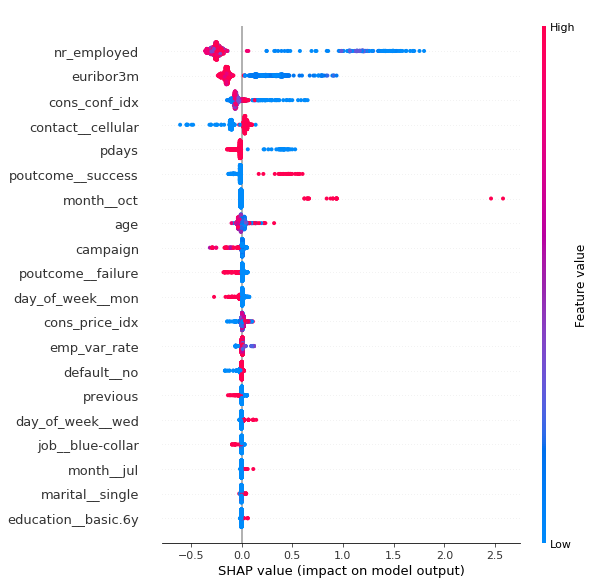

In [88]:
shap.summary_plot(shap_values, features=observations, feature_names=all_features)

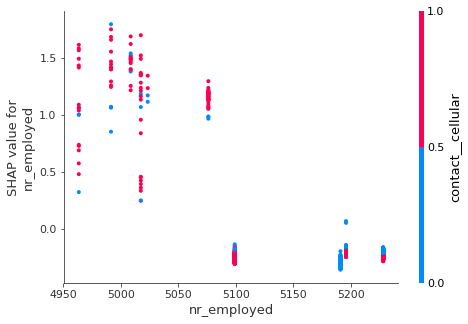

In [90]:
shap.dependence_plot("nr_employed", shap_values, 
                     pd.DataFrame(observations, columns=all_features))